Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "test_22987_suffix50_11_CNN2_differentConfig_SGD_noHier"
showListOfSpecies = False

from configParser import ConfigParser, getModelName
config_parser = ConfigParser(experimentName)

import os
experimentName = os.path.join(experimentName, "selected-multi-trial")
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)
ts_genus = TrialStatistics.TrialStatistics(experimentName, "genus")

import dataLoader

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Iterate

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from confusion_matrix_plotter import plot_confusion_matrix2, generate_classification_report
import numpy as np
import os
import progressbar

paramsIterator = config_parser.getHyperpSelectedIter()  
number_of_experiments = sum(1 for e in paramsIterator)
paramsIterator = config_parser.getHyperpSelectedIter()    
experiment_index = 0

datasetManager = dataLoader.datasetManager(experimentName, showListOfSpecies)
with progressbar.ProgressBar(max_value=number_of_experiments) as bar:
    for experiment_params in paramsIterator:
        bar.update(experiment_index)
        experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1

        print("experiment ", experiment_index+1, "/", number_of_experiments, ": ", experiment_params)

        # load images
        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
        speciesList = dataset.getSpeciesList()
        numberOfSpecies = len(speciesList)
        numberOfGenus = len(dataset.getGenusList())

        for i in range(experiment_params["numOfTrials"]):
            trialName = os.path.join(experimentName, getModelName(experiment_params, i))

            # Train/Load model
            architecture = {
                "species": numberOfSpecies,
                "genus" : numberOfGenus
            }
            model = CNN.create_model(architecture, experiment_params)
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            if os.path.exists(CNN.getModelFile(trialName)):
                _, _, epochs, time_elapsed = CNN.loadModel(model, trialName)
                print("Model {0} loaded!".format(trialName))
            else:
                _, _, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, experiment_params, model, trialName)

            # Update trial outcomes for statistics
            predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params)
            ts.addTrialPredictions(experiment_params, predlist, lbllist, numberOfSpecies)
            macro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')
            macro_f1_genus = np.nan
            if experiment_params["useHeirarchy"]:
                predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params, 'genus')
                ts_genus.addTrialPredictions(experiment_params, predlist, lbllist, numberOfGenus)
                macro_f1_genus = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

            ts.addTrial(experiment_params,
                    {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, experiment_params),
                     'accuracy': CNN.getAccuracyFromLoader(test_loader, model, experiment_params),
                     'macro_f1_species': macro_f1,
                     'macro_f1_genus': macro_f1_genus,
                     'time': time_elapsed,
                     'epochs': epochs
                    }, i)
        
        experiment_index = experiment_index + 1

N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  1 / 5 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 1e-05, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}
Loading dataset...
Going through image files


100% (550 of 550) |######################| Elapsed Time: 0:00:42 Time:  0:00:42


dataset has a mean: tensor([0.7661, 0.7249, 0.6513]) and std: tensor([0.1420, 0.1753, 0.2096])
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_SGD_noHier/selected-multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nTrue/dataset.pkl written
using a pretrained resnet model...
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_SGD_noHier/selected-multi-trial/trainingIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_SGD_noHier/selected-multi-trial/valIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_SGD_noHier/selected-multi-trial/testIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_SGD_noHier/selected-multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nTrue/trainingLoader.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_SGD_noHier/selected-multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nTrue/testLoader.pkl written
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 1:49:29 Time:  1:49:29


Early stopping
total number of epochs:  542


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:22:14 Time:  3:22:14
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:17:23 Time:  3:17:23
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  2 / 5 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}
using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:16:56 Time:  3:16:56
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:16:54 Time:  3:16:54
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:17:10 Time:  3:17:10
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  3 / 5 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}
using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:16:38 Time:  3:16:38
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:16:00 Time:  3:16:00
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:15:57 Time:  3:15:57
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  4 / 5 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}
using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:17:58 Time:  3:17:58
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:17:43 Time:  3:17:43
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:21:02 Time:  3:21:02
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  5 / 5 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.1, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}
using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 2:52:54 Time:  2:52:54


Early stopping
total number of epochs:  883


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 0:19:57 Time:  0:19:57


Early stopping
total number of epochs:  101


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

using a pretrained resnet model...
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 3:08:51 Time:  3:08:51


Early stopping
total number of epochs:  965


100% (5 of 5) |###########| Elapsed Time: 1 day, 20:31:14 Time: 1 day, 20:31:14


Analyze

In [5]:
ts.showStatistics()
ts.saveStatistics()

Aggregated statistics


In [6]:
ts.showStatistics(False)
ts.saveStatistics(False)

Raw statistics


,image_path,suffix,training_count,validation_count,imageDimension,n_channels,augmentation,batchSize,n_epochs,learning_rate,numOfTrials,patience,useHeirarchy,useRelu,downsample,downsampleOutput,takeFromIntermediate,takeFromIntermediateOutput,useAdam,resnet,normalize,loss,accuracy,macro_f1_species,macro_f1_genus,time,epochs,hash,trial
0,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00001,3,100,False,False,True,50,True,50,False,18,True,2.543862,0.036364,0.022059,NaN,6569.231894,543,4884300800086152312,0
1,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00001,3,100,False,False,True,50,True,50,False,18,True,2.456769,0.109091,0.072189,NaN,12134.226878,1000,4884300800086152312,1
2,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00001,3,100,False,False,True,50,True,50,False,18,True,2.472519,0.081818,0.055563,NaN,11843.151162,1000,4884300800086152312,2
3,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00010,3,100,False,False,True,50,True,50,False,18,True,2.268876,0.218182,0.177188,NaN,11816.519615,1000,6621520004918161071,0
4,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00010,3,100,False,False,True,50,True,50,False,18,True,2.300174,0.254545,0.170157,NaN,11814.256553,1000,6621520004918161071,1
5,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00010,3,100,False,False,True,50,True,50,False,18,True,2.312382,0.154545,0.092039,NaN,11830.218211,1000,6621520004918161071,2
6,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00100,3,100,False,False,True,50,True,50,False,18,True,1.583985,0.581818,0.518283,NaN,11798.552978,1000,8059596461837455610,0
7,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00100,3,100,False,False,True,50,True,50,False,18,True,1.654529,0.518182,0.413820,NaN,11759.988575,1000,8059596461837455610,1
8,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.00100,3,100,False,False,True,50,True,50,False,18,True,1.547625,0.600000,0.543251,NaN,11756.989335,1000,8059596461837455610,2
9,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01000,3,100,False,False,True,50,True,50,False,18,True,1.102712,0.636364,0.582210,NaN,11878.305976,1000,8163155092978710202,0


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 1e-05, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}


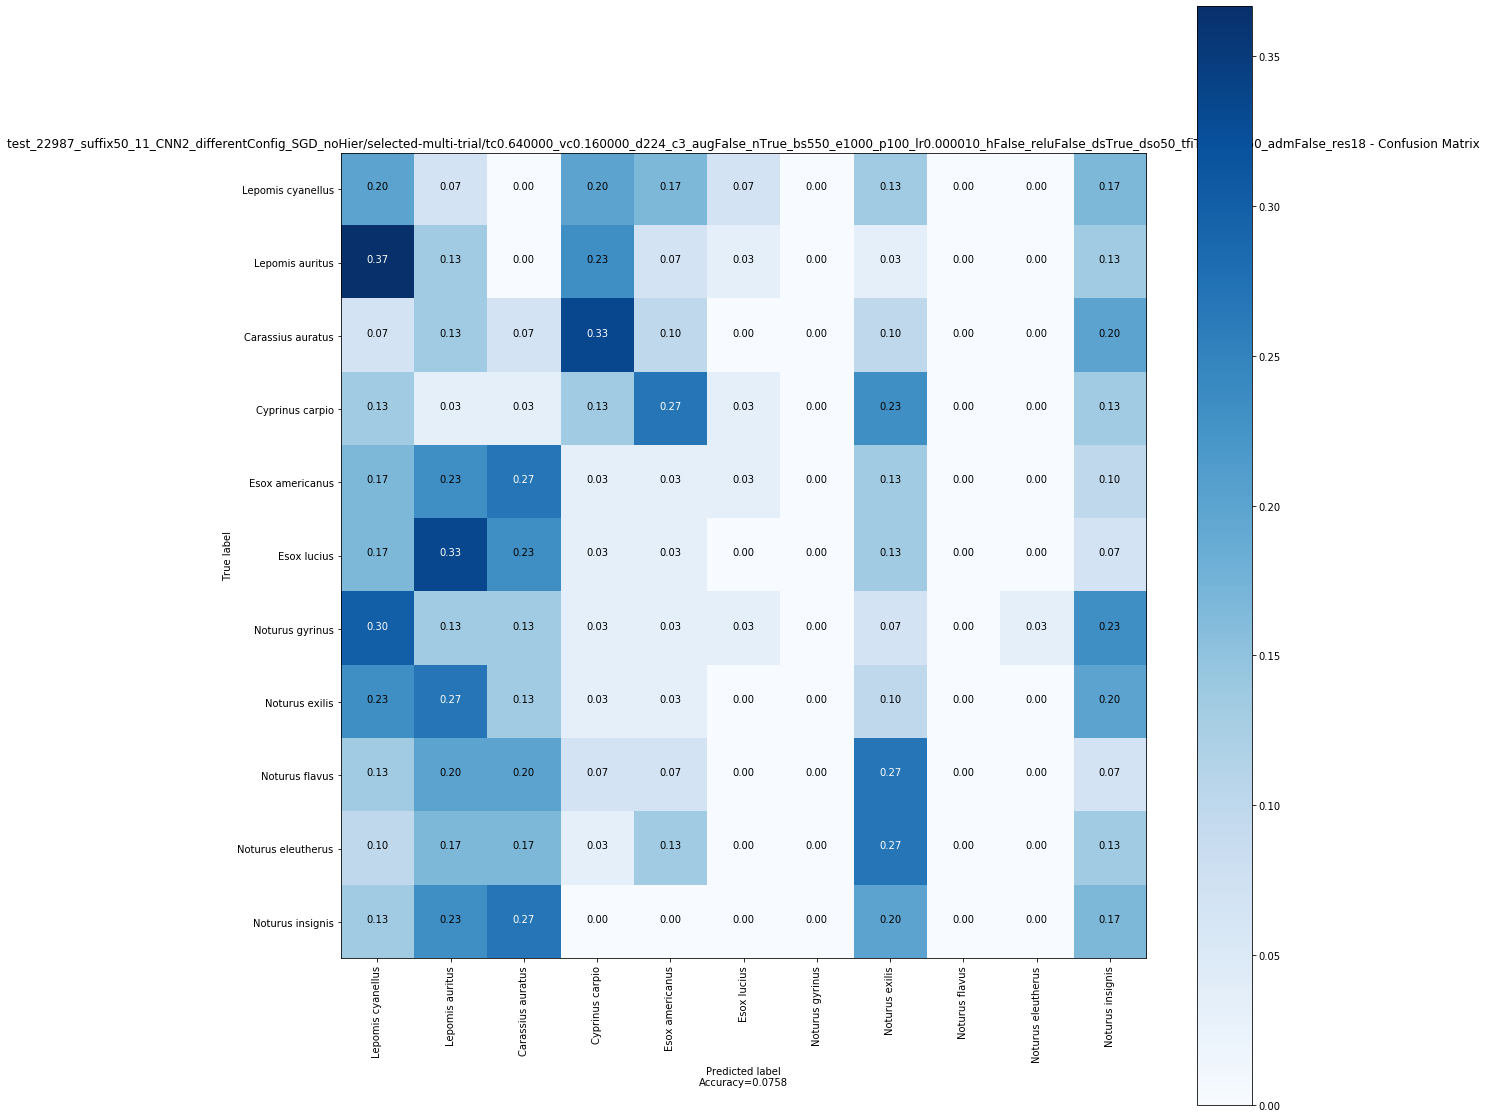

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.133333,0.480000,0.155844
1,1 Lepomis auritus,0 Lepomis,0.090909,0.380952,0.106667
2,2 Carassius auratus,1 Carassius,0.053333,1.000000,0.053333
3,3 Cyprinus carpio,2 Cyprinus,0.125000,1.000000,0.125000
4,4 Esox americanus,3 Esox,0.034483,0.500000,0.035714
5,5 Esox lucius,3 Esox,0.000000,0.000000,0.000000
6,6 Noturus gyrinus,4 Noturus,0.000000,0.000000,0.000000
7,7 Noturus exilis,4 Noturus,0.075000,0.166667,0.120000
8,8 Noturus flavus,4 Noturus,0.000000,0.000000,0.000000
9,9 Noturus eleutherus,4 Noturus,0.000000,0.000000,0.000000


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}


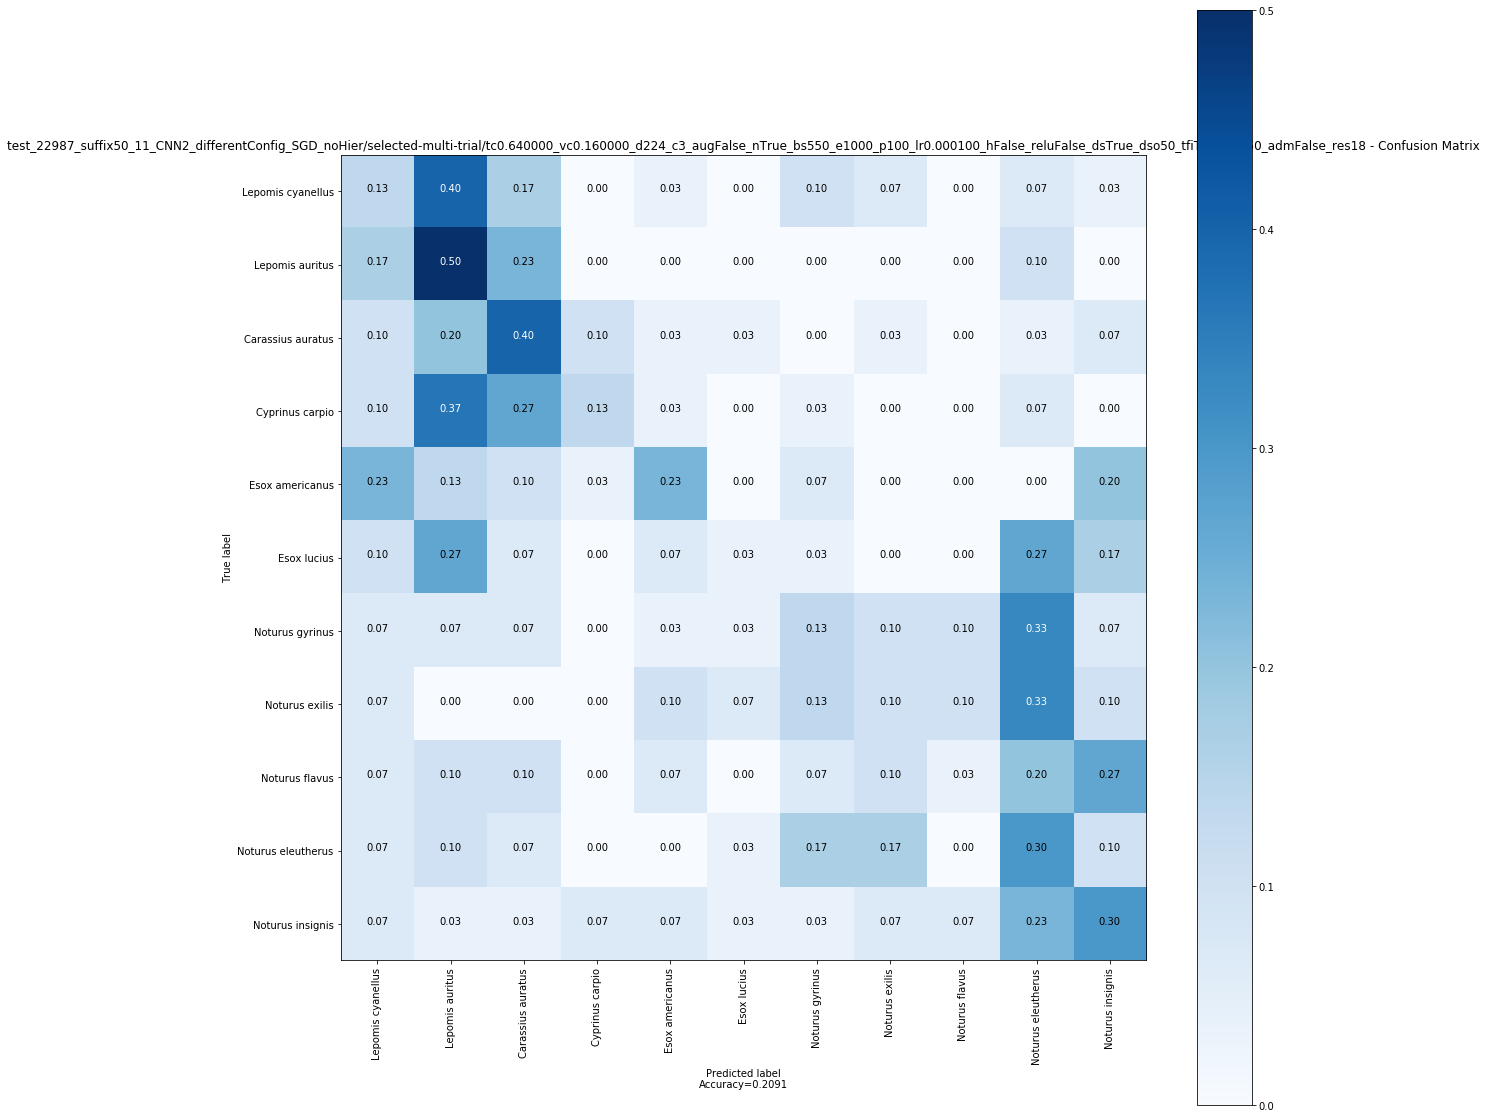

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.123077,0.320000,0.166667
1,1 Lepomis auritus,0 Lepomis,0.315789,0.638298,0.384615
2,2 Carassius auratus,1 Carassius,0.320000,1.000000,0.320000
3,3 Cyprinus carpio,2 Cyprinus,0.200000,1.000000,0.200000
4,4 Esox americanus,3 Esox,0.280000,0.875000,0.291667
5,5 Esox lucius,3 Esox,0.054054,0.500000,0.057143
6,6 Noturus gyrinus,4 Noturus,0.150943,0.210526,0.347826
7,7 Noturus exilis,4 Noturus,0.122449,0.153846,0.375000
8,8 Noturus flavus,4 Noturus,0.051282,0.068966,0.166667
9,9 Noturus eleutherus,4 Noturus,0.204545,0.281250,0.428571


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}


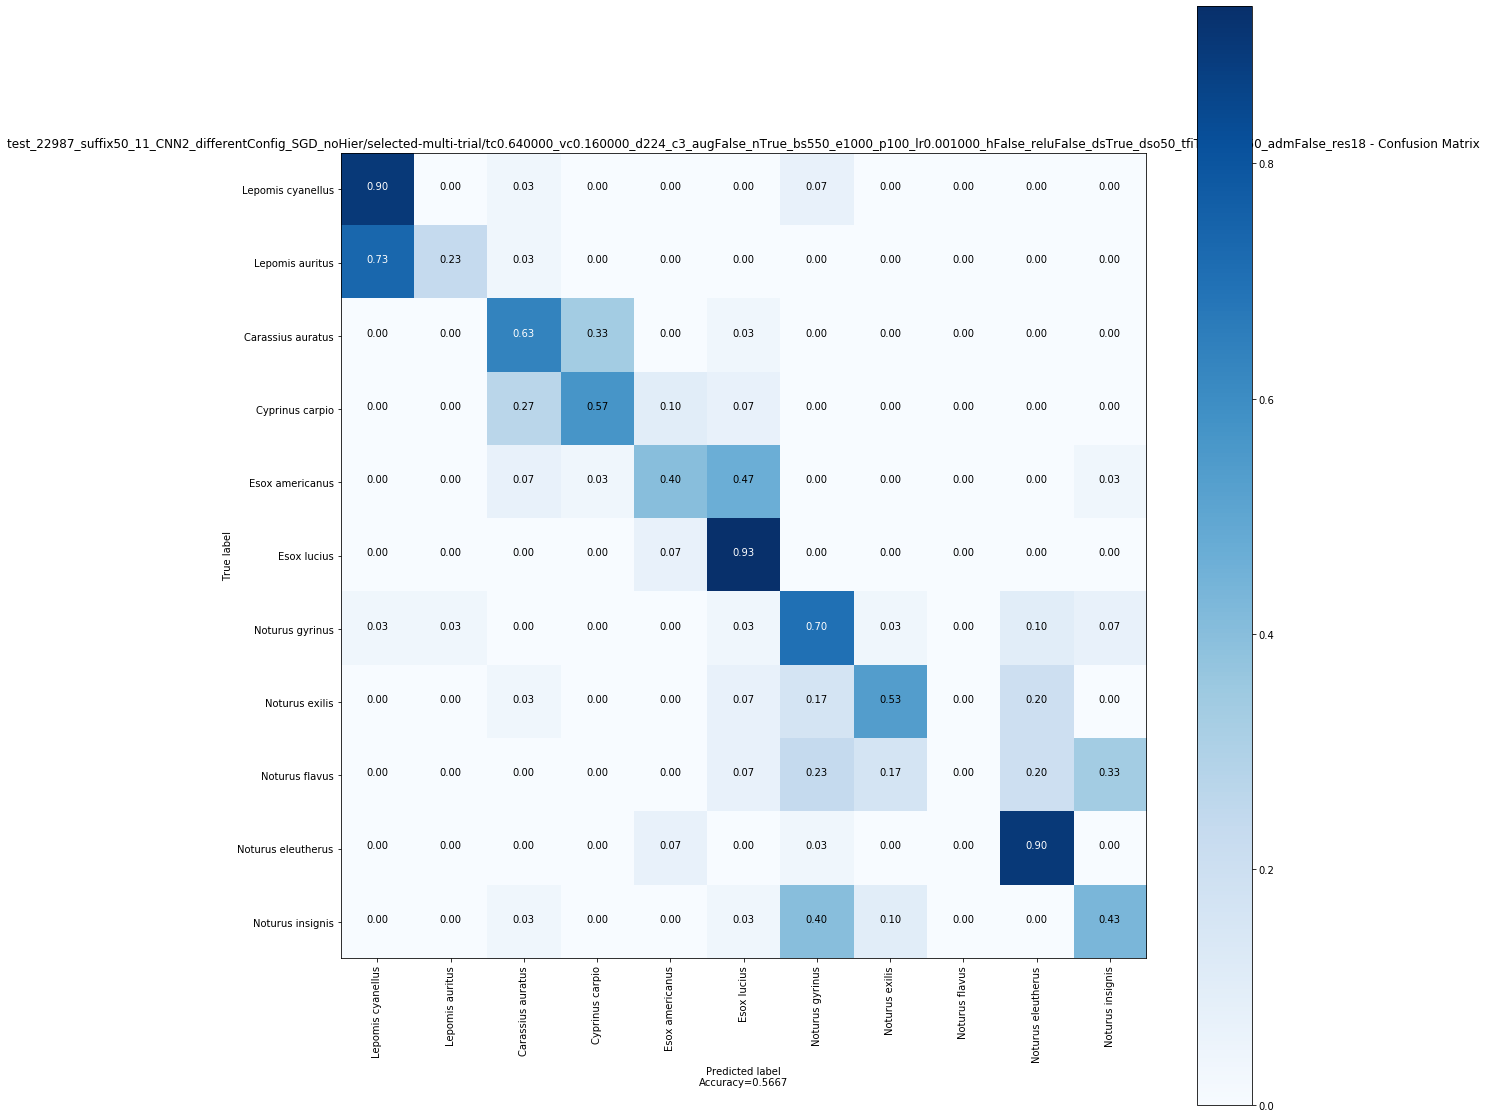

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.675000,0.710526,0.931034
1,1 Lepomis auritus,0 Lepomis,0.368421,0.388889,0.875000
2,2 Carassius auratus,1 Carassius,0.603175,1.000000,0.603175
3,3 Cyprinus carpio,2 Cyprinus,0.586207,1.000000,0.586207
4,4 Esox americanus,3 Esox,0.489796,0.600000,0.727273
5,5 Esox lucius,3 Esox,0.691358,0.777778,0.861538
6,6 Noturus gyrinus,4 Noturus,0.538462,0.575342,0.893617
7,7 Noturus exilis,4 Noturus,0.581818,0.615385,0.914286
8,8 Noturus flavus,4 Noturus,0.000000,0.000000,0.000000
9,9 Noturus eleutherus,4 Noturus,0.750000,0.771429,0.964286


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}


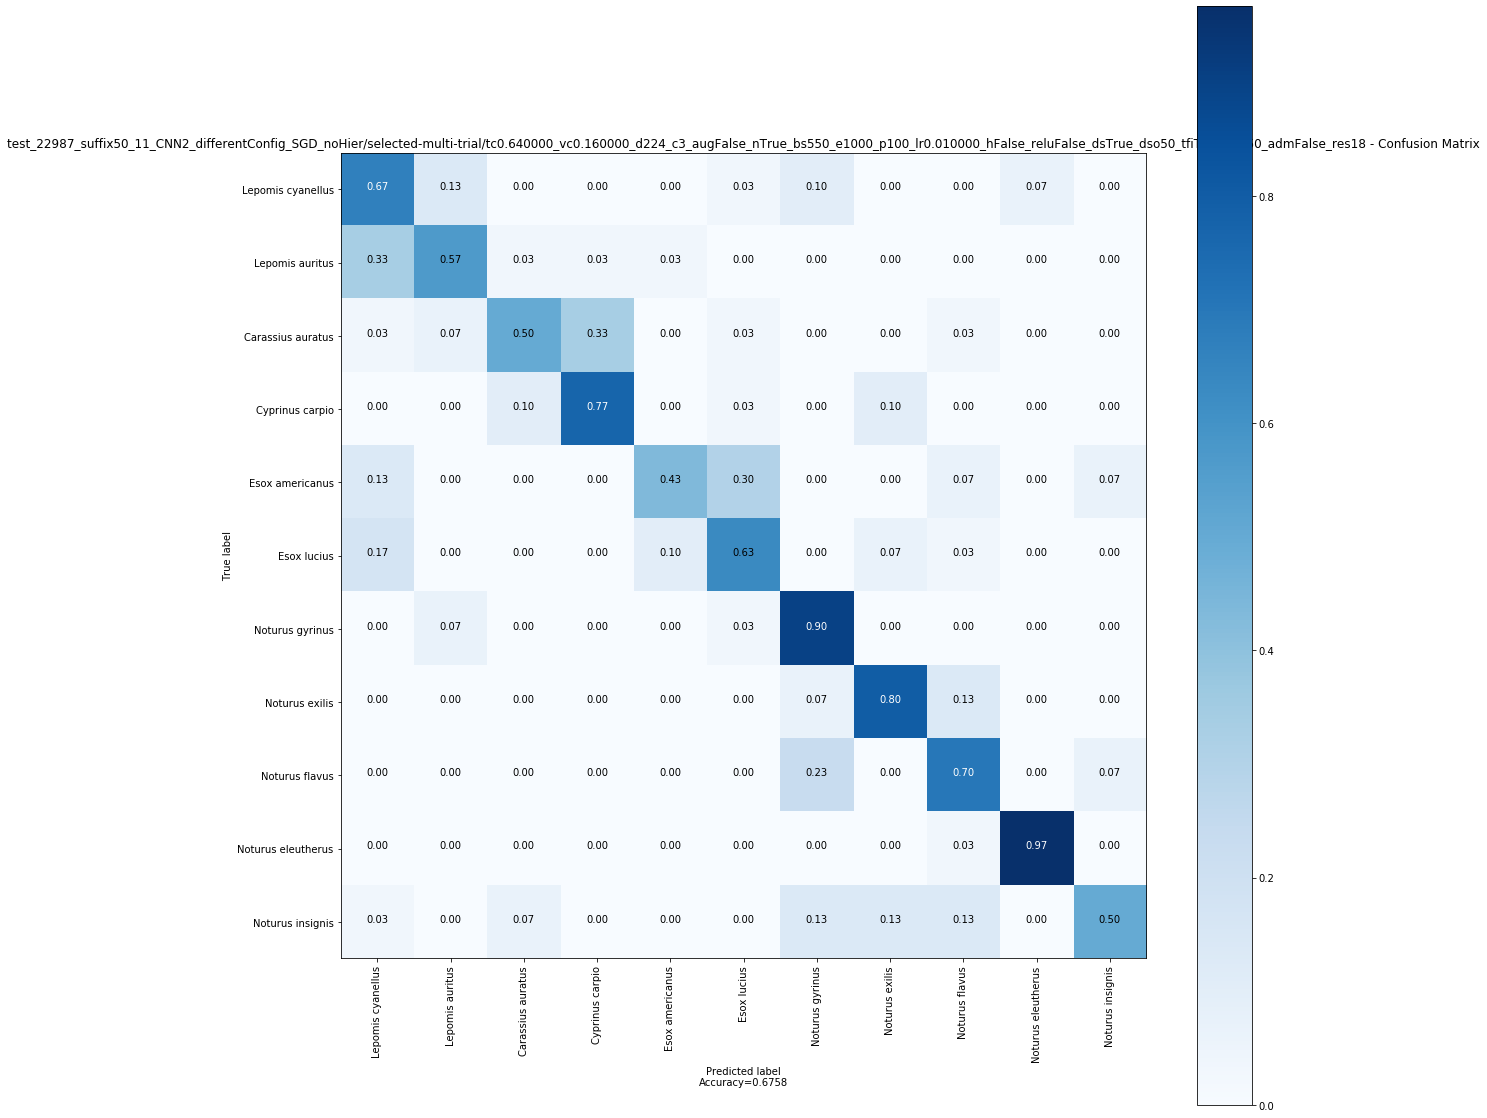

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.563380,0.740741,0.701754
1,1 Lepomis auritus,0 Lepomis,0.618182,0.708333,0.829268
2,2 Carassius auratus,1 Carassius,0.588235,1.000000,0.588235
3,3 Cyprinus carpio,2 Cyprinus,0.718750,1.000000,0.718750
4,4 Esox americanus,3 Esox,0.553191,0.684211,0.742857
5,5 Esox lucius,3 Esox,0.612903,0.760000,0.760000
6,6 Noturus gyrinus,4 Noturus,0.739726,0.805970,0.900000
7,7 Noturus exilis,4 Noturus,0.761905,0.827586,0.905660
8,8 Noturus flavus,4 Noturus,0.656250,0.700000,0.913043
9,9 Noturus eleutherus,4 Noturus,0.950820,0.983051,0.966667


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.1, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': False, 'useRelu': False, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'useAdam': False, 'resnet': '18', 'normalize': True}


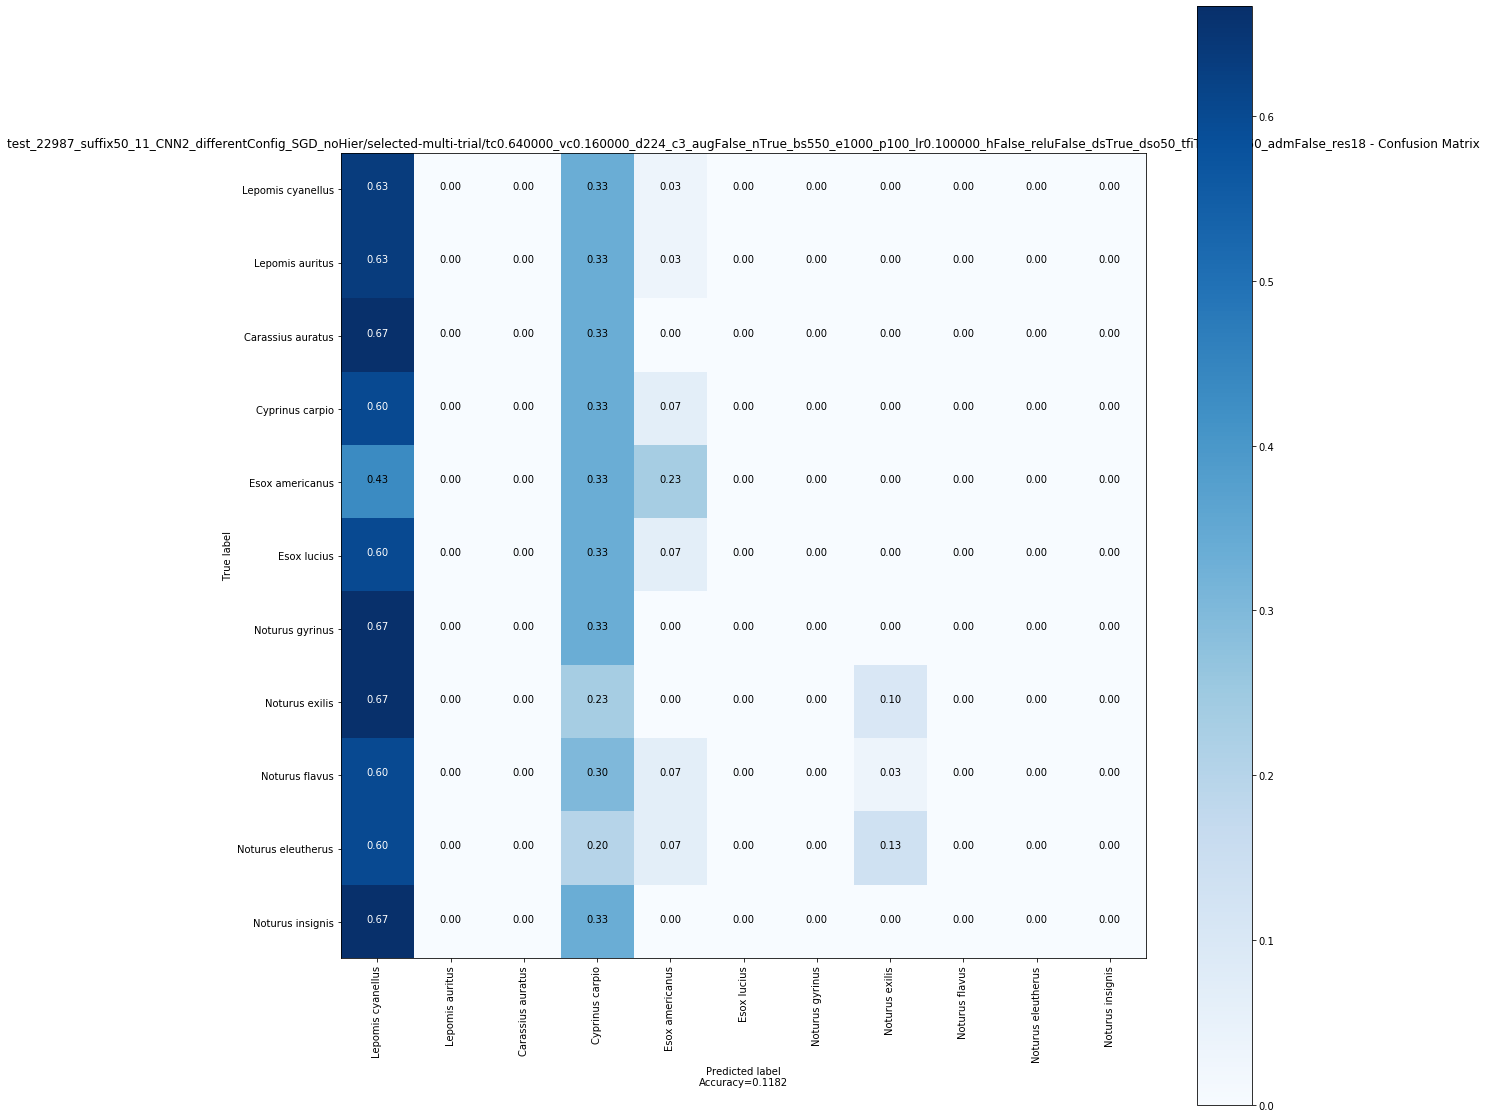

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.163090,0.666667,0.177570
1,1 Lepomis auritus,0 Lepomis,0.000000,0.000000,0.000000
2,2 Carassius auratus,1 Carassius,0.000000,0.000000,0.000000
3,3 Cyprinus carpio,2 Cyprinus,0.151515,1.000000,0.151515
4,4 Esox americanus,3 Esox,0.297872,0.875000,0.311111
5,5 Esox lucius,3 Esox,0.000000,0.000000,0.000000
6,6 Noturus gyrinus,4 Noturus,0.000000,0.000000,0.000000
7,7 Noturus exilis,4 Noturus,0.157895,0.545455,0.181818
8,8 Noturus flavus,4 Noturus,0.000000,0.000000,0.000000
9,9 Noturus eleutherus,4 Noturus,0.000000,0.000000,0.000000


In [7]:
paramsIterator = config_parser.getHyperpSelectedIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    
    print("experiment: ", experiment_params)
    
    datasetManager.updateParams(experiment_params)
    dataset = datasetManager.getDataset()
    speciesList = dataset.getSpeciesList()
    ts.printTrialConfusionMatrix(experiment_params, speciesList, True)
    ts.printF1table(experiment_params, dataset)

In [8]:
paramsIterator = config_parser.getHyperpSelectedIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    if experiment_params["useHeirarchy"]:
        print("experiment: ", experiment_params)

        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
    
        genusList = dataset.getGenusList()
        ts_genus.printTrialConfusionMatrix(experiment_params, genusList, True)
        ts_genus.printF1table(experiment_params, dataset)

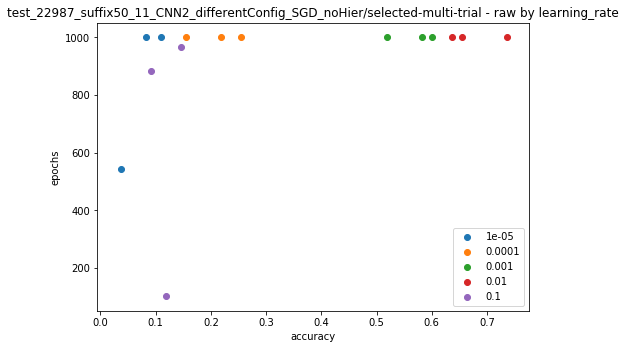

In [9]:
ts.trialScatter('accuracy', 'epochs', False, 'learning_rate')

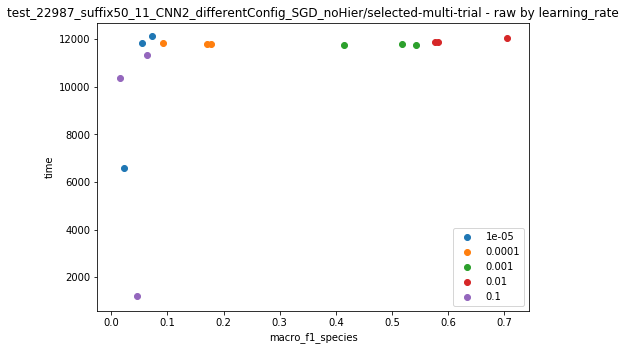

In [11]:
ts.trialScatter('macro_f1_species', 'time', False, 'learning_rate')